# Cardiovascular risks

In [1]:
## Importation des librairies nécessaires au bon déroulement du projet.
# Analyse Exploratoire
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Normalisation des variables
from sklearn.preprocessing import StandardScaler

# Test des hyperparamètres pour la régression logistique
from sklearn.model_selection import GridSearchCV

# Regressions logistiques + Visualisation de la courbe ROC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
# paramètres/préférences d'affichage seaborn
sns.set(style='darkgrid', font_scale=1.5)

# Sommaire :
    1. Analyse Exploratoire du jeu de données
    2. Visualisation du jeu de données
    3. Réalisation de regression logistique 
        - Sklearn
        - Mon modèle
    4. Évaluation des modèles de régression logistique
    5. Prédiction pour le patient Arthur

## 1. Analyse Exploratoire du jeu de données.
    - Importation du jeu de données
    - Visualisation des données / Informations sur les données
    - Pré-traitement et nettoyage des données

In [3]:
# Importation du dataframe
df = pd.read_csv('csv/cardio_train.csv', delimiter=";")

In [4]:
# Conversion de l'âge en années et arrondissement à l'entier le plus proche
df['age'] = df['age'] / 365
df['age'] = df['age'].apply(lambda x: round(x))

In [5]:
# Visualisation des données
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
# Informations générale
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Aucune valeur manquante.
La totalité de nos données est numérique, vous trouverez un descriptif détaillé du type de nos données dans le ReadMe.

### Suppression des colonnes inutiles ansi que des doublons.

In [7]:
# Suppression des colonnes inutiles
df = df.drop(columns=['id'])

In [8]:
# Affichage et suppression des valeurs dupliquées
print(f'Total des valeurs dupliquées : {df.duplicated().sum()}')
df = df.drop_duplicates().reset_index(drop=True)

Total des valeurs dupliquées : 3816


In [9]:
# Afficher le pourcentage de valeurs aberrantes supprimées
print(f"Pourcentage de valeurs supprimées à ce stade: {(70000 - df.shape[0]) / 70000 * 100:.2f}%")

Pourcentage de valeurs supprimées à ce stade: 5.45%


### Statistiques descriptives (moyenne, médiane, écart-type, etc.)

In [10]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000,66184.000000
mean,53.365209,1.357231,164.345114,74.579057,129.304938,97.607186,1.385985,1.238169,0.092772,0.056751,0.797625,0.513614
std,6.807710,0.479187,8.353877,14.613279,158.368179,193.782532,0.692229,0.584137,0.290114,0.231368,0.401773,0.499818
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,59.000000,2.000000,170.000000,83.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


**À cette étape, on remarque déjà que notre dataset contient des valeurs aberrantes ; notamment les valeurs min/max des variables ap_hi et ap_lo).**

### Voyons de plus près la distibution de ces dernières au sein de notre jeu de données :
    on s'aidera de boxplot pour ce faire.

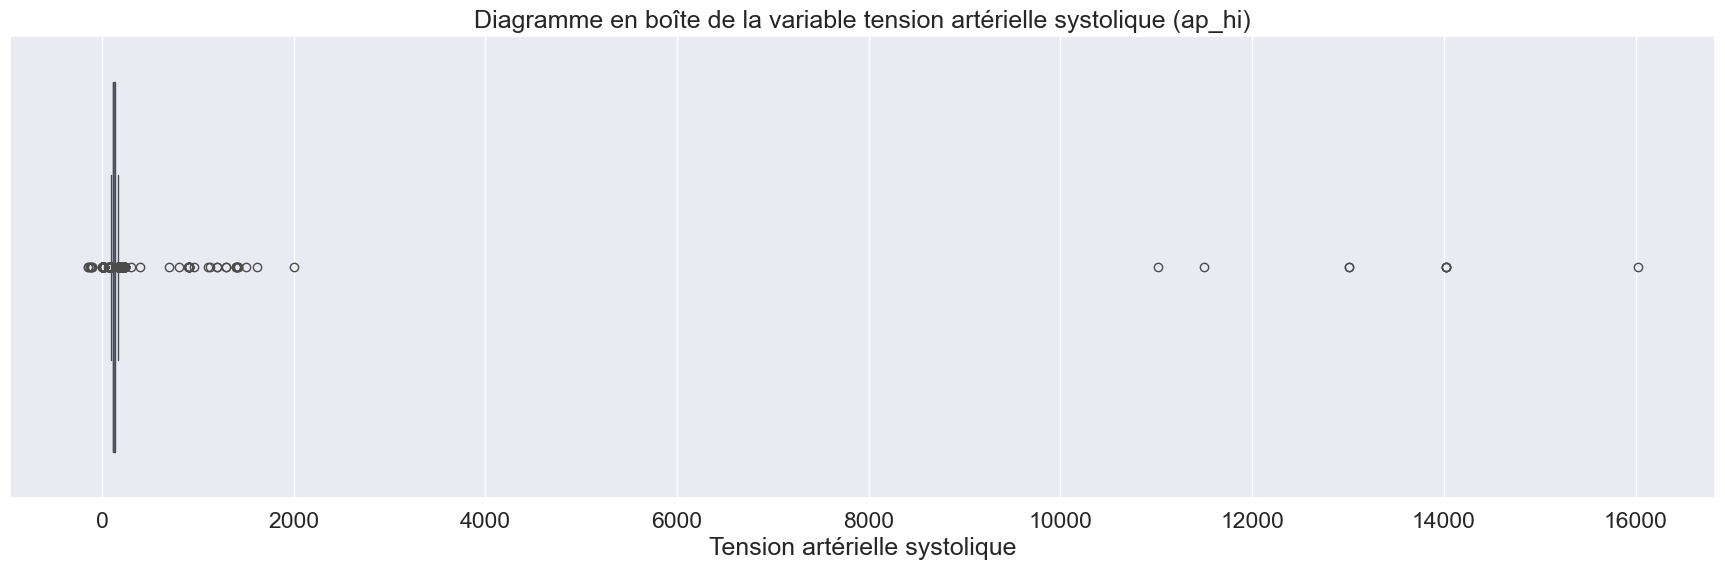

In [11]:
plt.figure(figsize=(22, 6))
sns.boxplot(x='ap_hi', data=df)
plt.title('Diagramme en boîte de la variable tension artérielle systolique (ap_hi)')
plt.xlabel('Tension artérielle systolique')
plt.show()

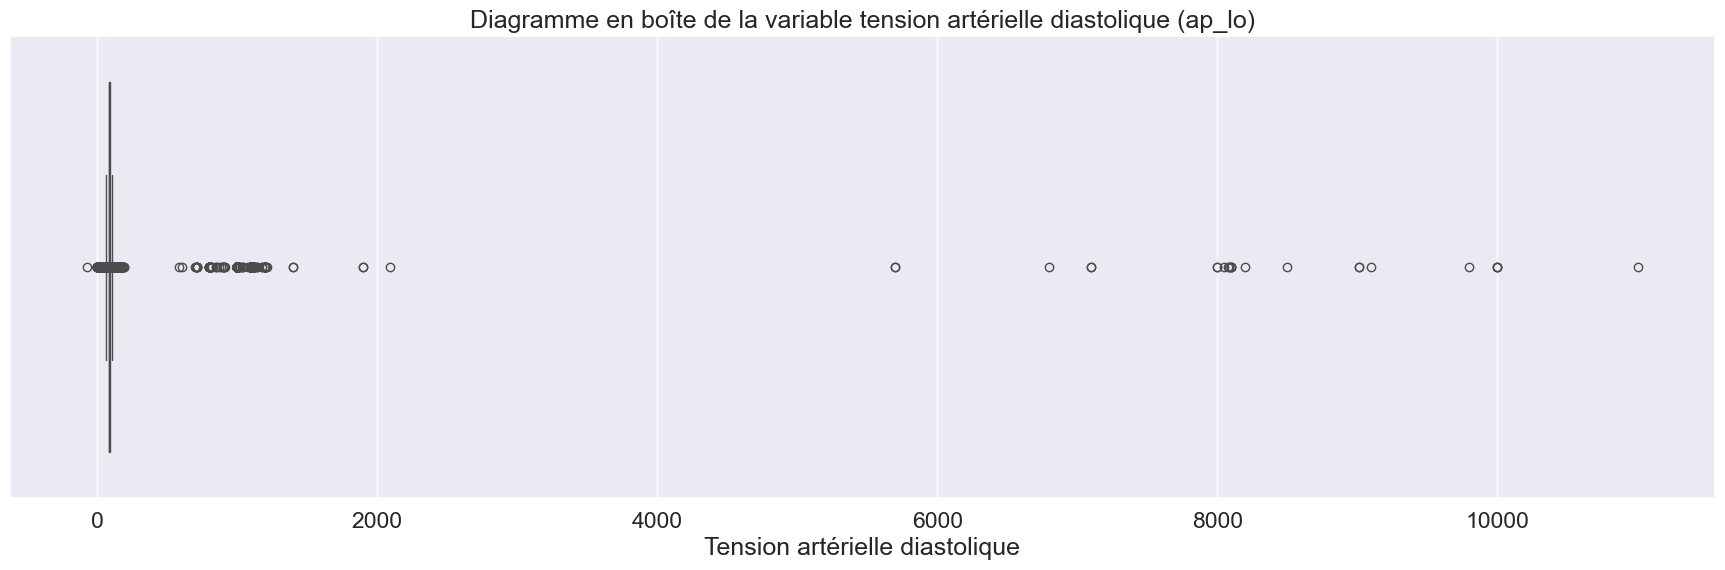

In [12]:
plt.figure(figsize=(22, 6))
sns.boxplot(x='ap_lo', data=df)
plt.title('Diagramme en boîte de la variable tension artérielle diastolique (ap_lo)')
plt.xlabel('Tension artérielle diastolique')
plt.show()

**On remarque alors la présence d'une quantité importante de valeurs abérrantes.**

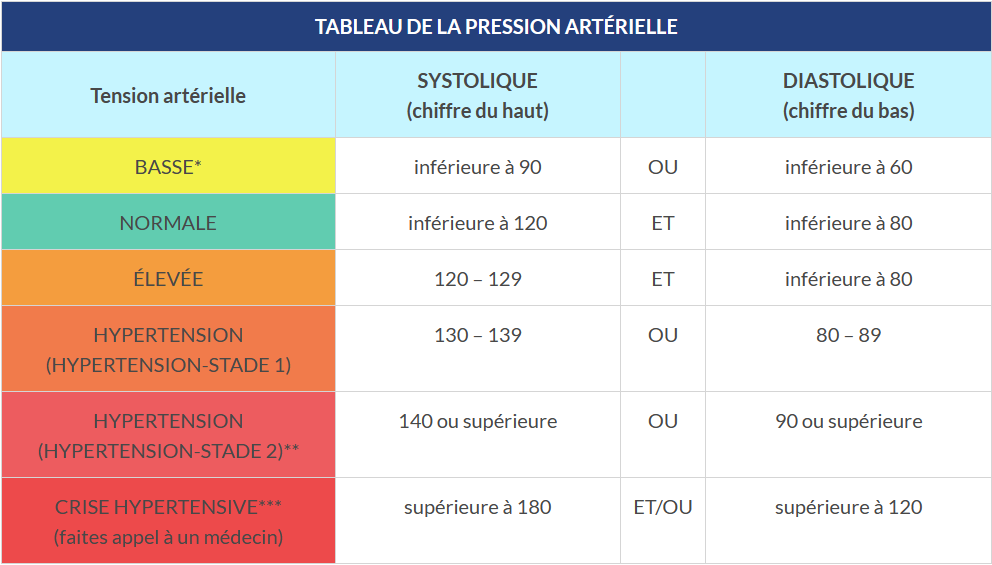

À l'aide du tableau ci-dessus, je décide de me débarasser des données qui ne correspondent pas à l'intervalle décrit.

In [13]:
df = df[(df['ap_hi'] > 90) & (df['ap_hi'] < 180)].reset_index(drop=True)
df = df[(df['ap_lo'] > 60) & (df['ap_lo'] < 120)].reset_index(drop=True)

df = df[(df['height'] > 140) & (df['height'] < 200)].reset_index(drop=True)
df = df[(df['weight'] > 50) & (df['weight'] < 200)].reset_index(drop=True)

Voyons voir maintenant la distribution de nos données, toujours en se concentrant sur les varriables `ap_hi` et `ap_lo` :

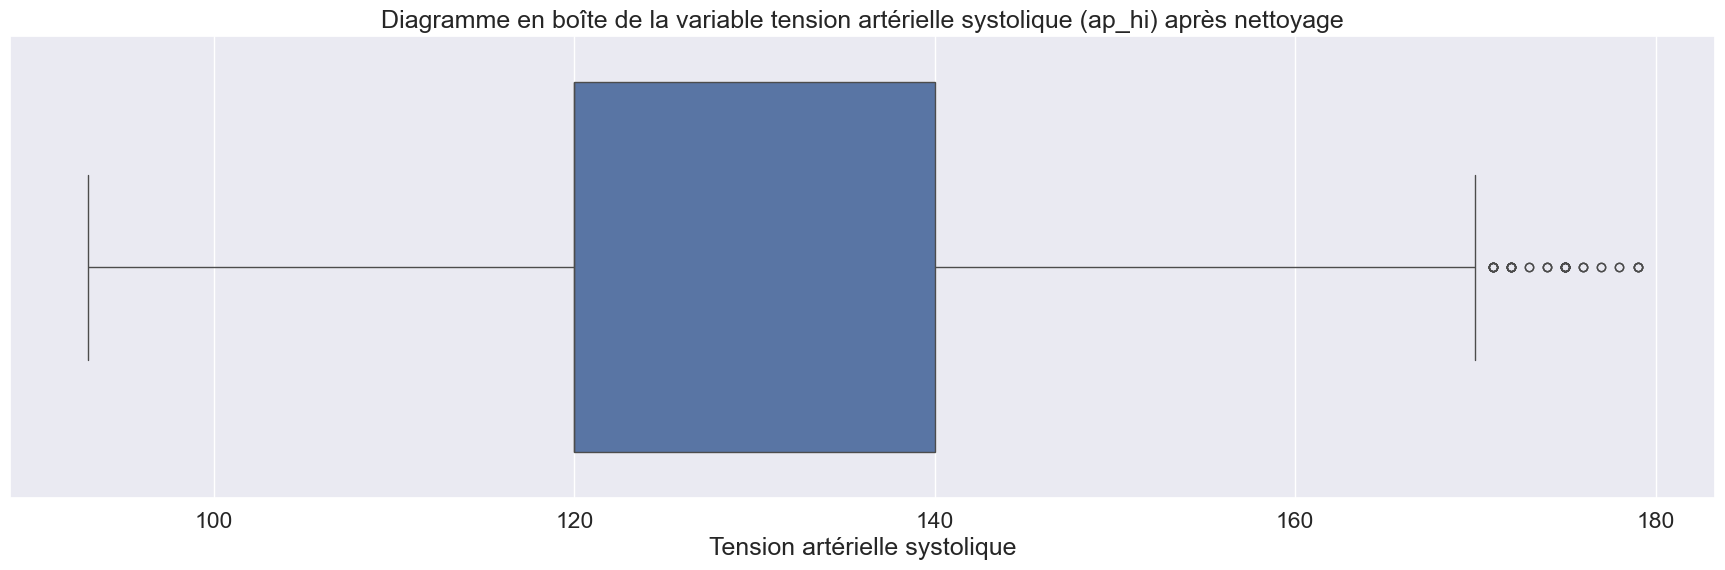

In [14]:
plt.figure(figsize=(22, 6))
sns.boxplot(x='ap_hi', data=df)
plt.title('Diagramme en boîte de la variable tension artérielle systolique (ap_hi) après nettoyage')
plt.xlabel('Tension artérielle systolique')
plt.show()

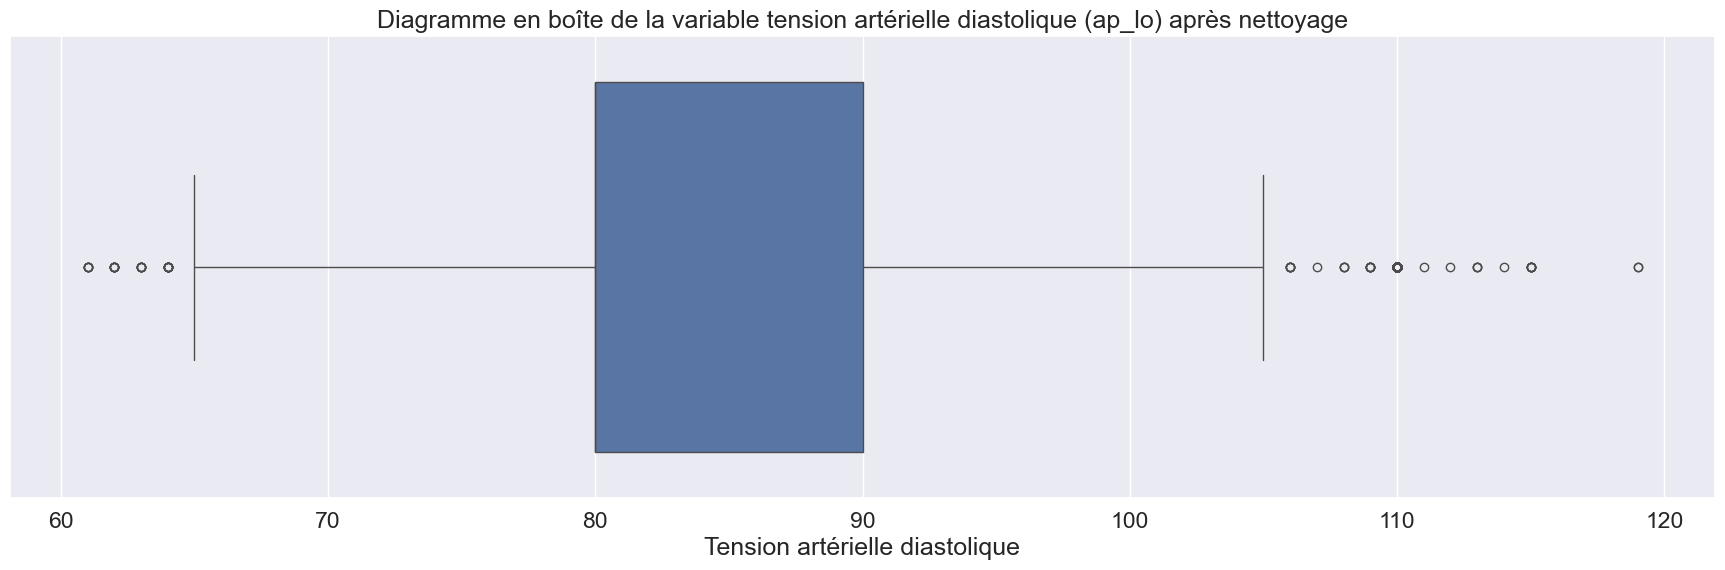

In [15]:
plt.figure(figsize=(22, 6))
sns.boxplot(x='ap_lo', data=df)
plt.title('Diagramme en boîte de la variable tension artérielle diastolique (ap_lo) après nettoyage')
plt.xlabel('Tension artérielle diastolique')
plt.show()

In [16]:
print(f"Pourcentage total de valeurs supprimées: {(70000 - df.shape[0]) / 70000 * 100:.2f}%")

Pourcentage total de valeurs supprimées: 14.91%


### Ajout de variables 
    - L'indice de masse corporelle (IMC) / (bmi en anglais)
    - La pression artérielle moyenne (PAM) / (MAP en anglais)

#### Calcul de l'IMC 
**$$ IMC = \frac{poids(kg)}{taille(m^2)}$$**

In [17]:
# Ajout de la variable IMC au dataset
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

Interprétation de l'IMC selon les normes de l'OMS (Organisme Mondial de la Santé) :
- moins de 18,5 : insuffisance pondérale (sous-poids)
- entre 18,5 et 25 : corpulence normale
- entre 25 et 30 : sur-poids
- plus de 40 : obésité morbide ou massive

In [18]:
# Ajout de la variable IMC categorielle au dataset
df['bmi_cat'] = df['bmi'].apply(lambda x: 'Underweight' if x < 18.5 else ('Normal' if 18.5 <= x < 25 else ('Overweight' if 25 <= x < 30 else 'Obese')))
df['bmi_cat'] = df['bmi_cat'].astype('object')

#### Calcul de la pression artérielle moyenne (PAM)
Formule de Lian :
$$PAM = \frac{(2\times PAD) + PAS}{3}$$

PAS : préssion artérielle systolique   
PAD : préssion artérielle diastolique

In [19]:
# Ajout de la variable pression artérielle moyenne au dataset
df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3

Lecture de PAM normale et anormale :
- Une plage de PAM normale est généralement considérée comme comprise entre 70 et 100 mmHg.
- De faibles lectures de PAM, qui sont généralement considérées comme inférieures à 60 mmHg, peuvent indiquer une mauvaise circulation sanguine vers les organes et les tissus, entraînant des lésions ou une défaillance des organes.
- Des lectures élevées de PAM, qui sont généralement considérées comme supérieures à 110 mmHg, peuvent indiquer un risque accru d’accident vasculaire cérébral, de crise cardiaque et d’autres complications cardiovasculaires.

In [20]:
# Ajout de la variable pression artérielle moyenne categorielle au dataset
df['map_cat'] = df['map'].apply(lambda x: 'Normal' if 70 <= x < 100 else ('Low' if x < 60 else ('High' if x >= 100 else 'Hypertensive crisis')))
df['map_cat'] = df['map_cat'].astype('object')

### Statistiques descriptives après nettoyage du jeu de données.

In [21]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,map
count,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000,59560.000000
mean,53.461165,1.365883,164.754953,75.289293,127.420047,82.149144,1.389036,1.240715,0.093721,0.057304,0.796592,0.519862,27.791317,97.239445
std,6.770578,0.481681,7.814395,13.943013,14.723068,8.101546,0.696522,0.587939,0.291442,0.232424,0.402537,0.499610,5.141033,9.523320
min,30.000000,1.000000,141.000000,51.000000,93.000000,61.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.577259,72.333333
25%,49.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.092971,93.333333
50%,54.000000,1.000000,165.000000,73.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,26.753213,93.333333
75%,59.000000,2.000000,170.000000,83.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.486657,103.333333
max,65.000000,2.000000,198.000000,183.000000,179.000000,119.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,68.308315,137.666667


### Normalisation des données ... Quand ? et pourquoi ?

In [22]:
# # Sélection des variables à normaliser
# features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'map']

# # Initialisation du StandardScaler
# scaler = StandardScaler()

# # Normalisation des variables
# df[features] = scaler.fit_transform(df[features])

# # Affichage des statistiques descriptives du dataset
# df.describe()

## 2. Visualisation et Analyse des données.
    - Distribution des données du dataset
    - Carte (de chaleur) des corrélations
    

#### Distribution des données du dataset.

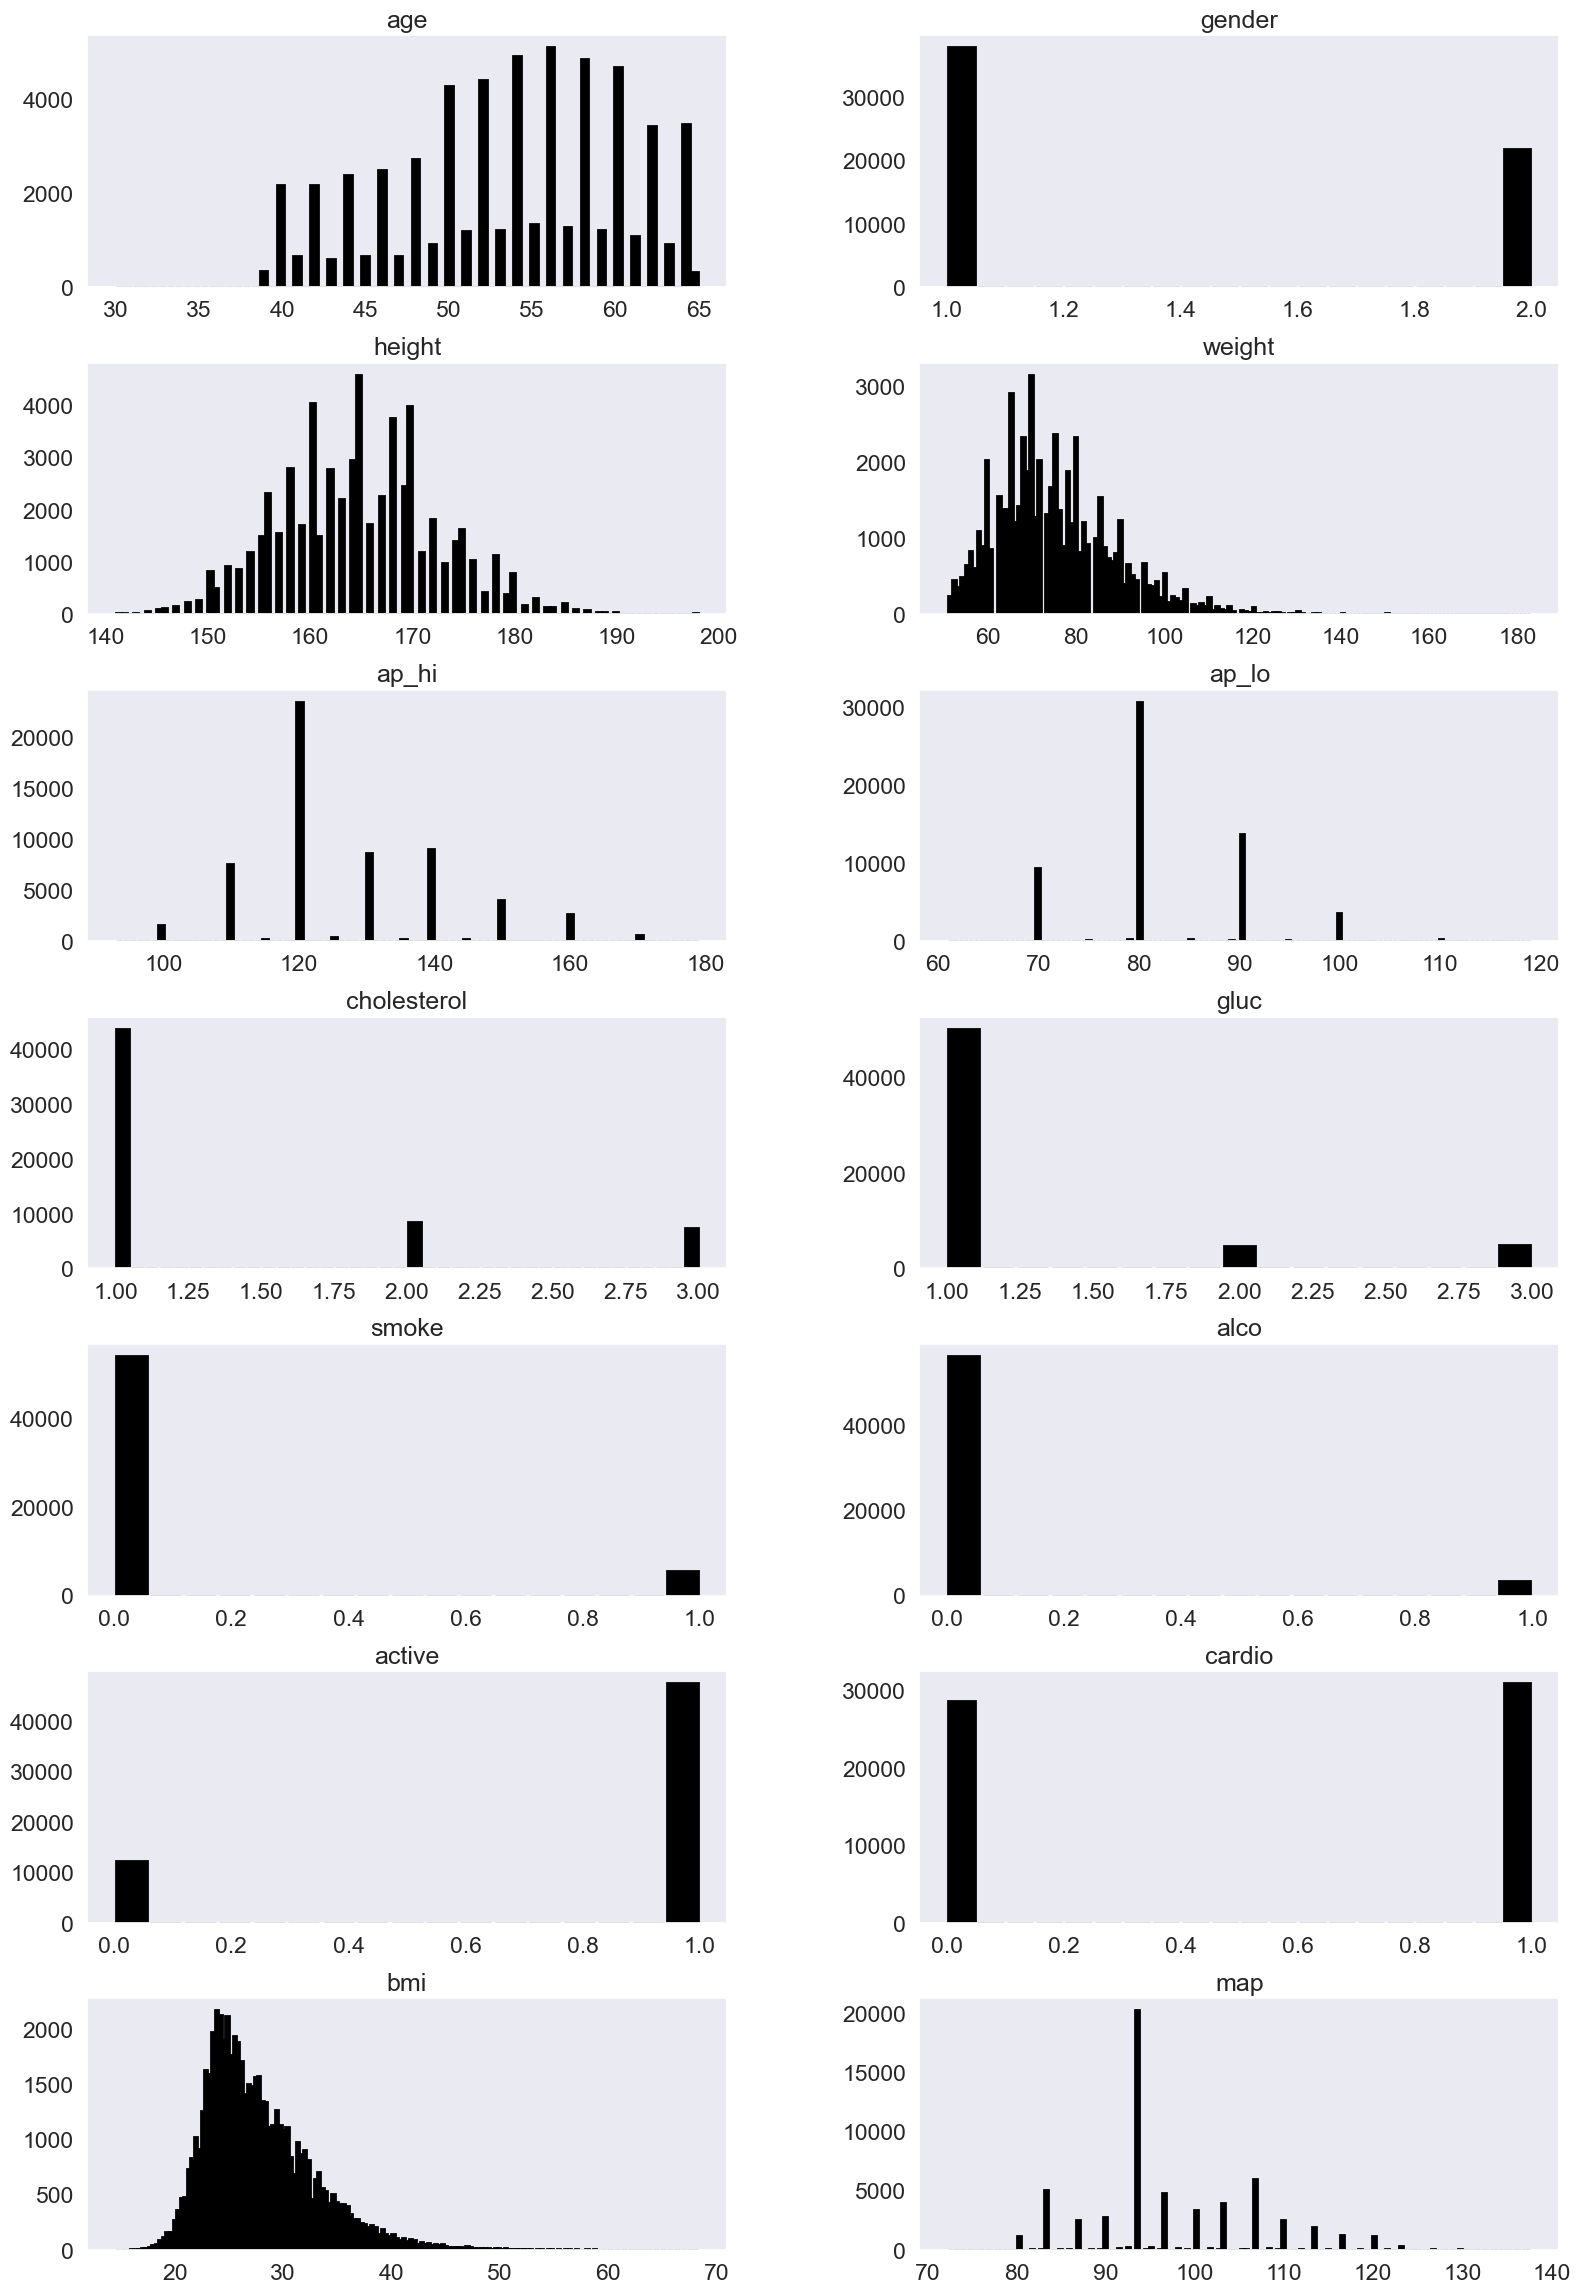

In [23]:
df.hist(figsize=(19, 50), color='black', bins='auto', grid=False, layout=(12, 2), edgecolor='black', linewidth=2, zorder=2, rwidth=0.9, histtype='bar', align='mid', orientation='vertical')
plt.show()

In [24]:
# Mes palettes de couleurs
gender = {
    1: 'tab:pink',
    2: 'tab:blue'
}
carisk = {
    0: 'tab:blue',
    1: 'tab:red'
}
artmean = {
    'Normal': 'tab:blue', 
    'High': 'tab:red'
}

### Pour une meilleure observation des changements proportionnels, les grapgiques suivants sont à l'echelle logarithmique.

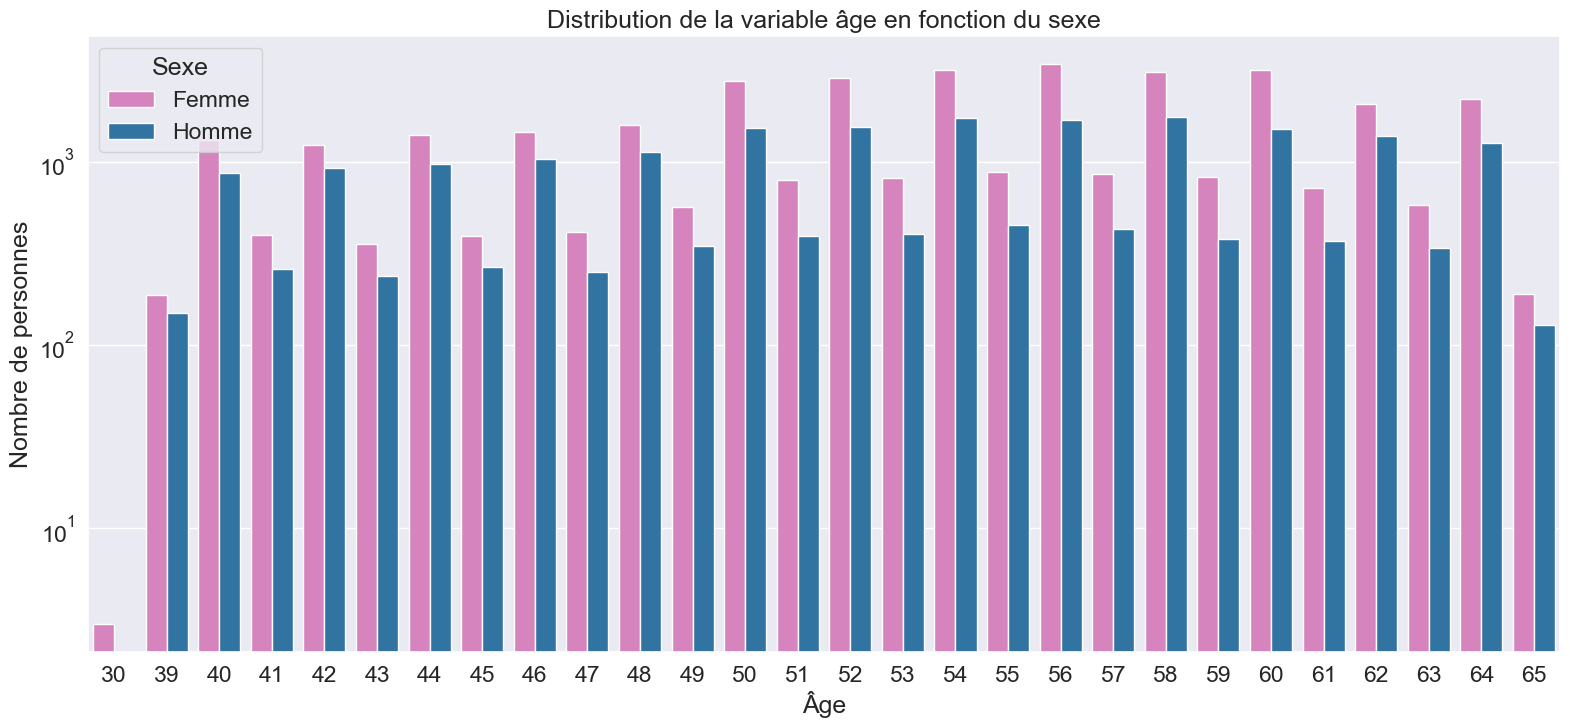

In [25]:
plt.figure(figsize=(19, 8))
sns.countplot(x='age', hue='gender', data=df, palette=gender)
plt.title('Distribution de la variable âge en fonction du sexe')
plt.legend(labels=['Femme', 'Homme'], title='Sexe')
plt.xlabel('Âge')
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

On observe que notre jeu de données est majoritairement plus représenté par des patients féminins que des patients masculins et ceci, quelque soit l'âge du patient.

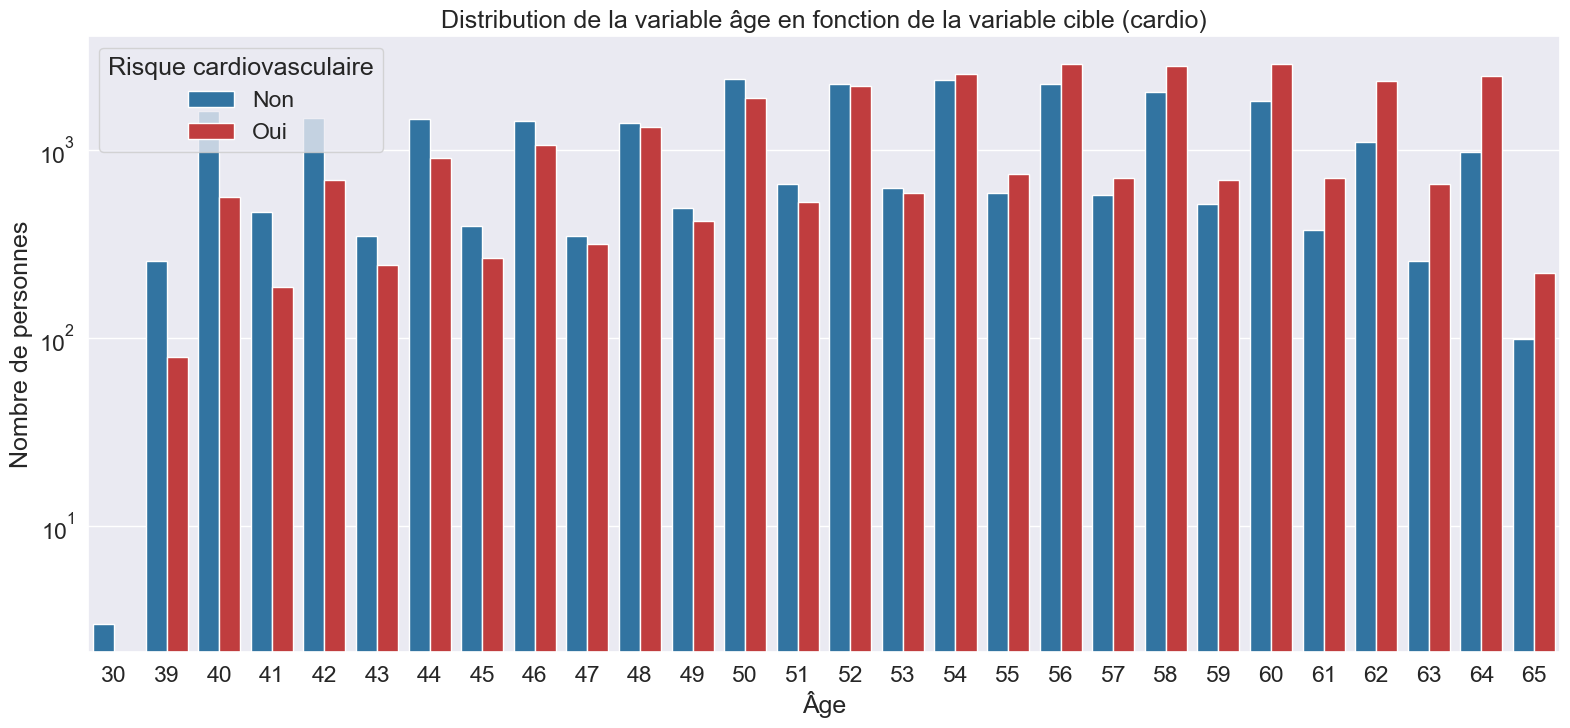

In [26]:
plt.figure(figsize=(19, 8))
sns.countplot(x='age', hue='cardio', data=df, palette=carisk)
plt.title('Distribution de la variable âge en fonction de la variable cible (cardio)')
plt.legend(loc='upper left', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Âge')
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

<!-- On observe ici la corrélation entre le risque de maladie cardio-vasculaire et l'âge : plus l'âge du patient augmente, plus ce dernier est sujet à des risques de maladies cardio-vasculaires.   
 -->
On observe ici que plus l'âge du patient augmente, plus les risques de contracter une maladie cardio-vasculaire augmentent.      
Les risques de maladie cardio-vasculaire sont plus importants à partir 54ans et pour l'intervalle des 54-65 ans. 

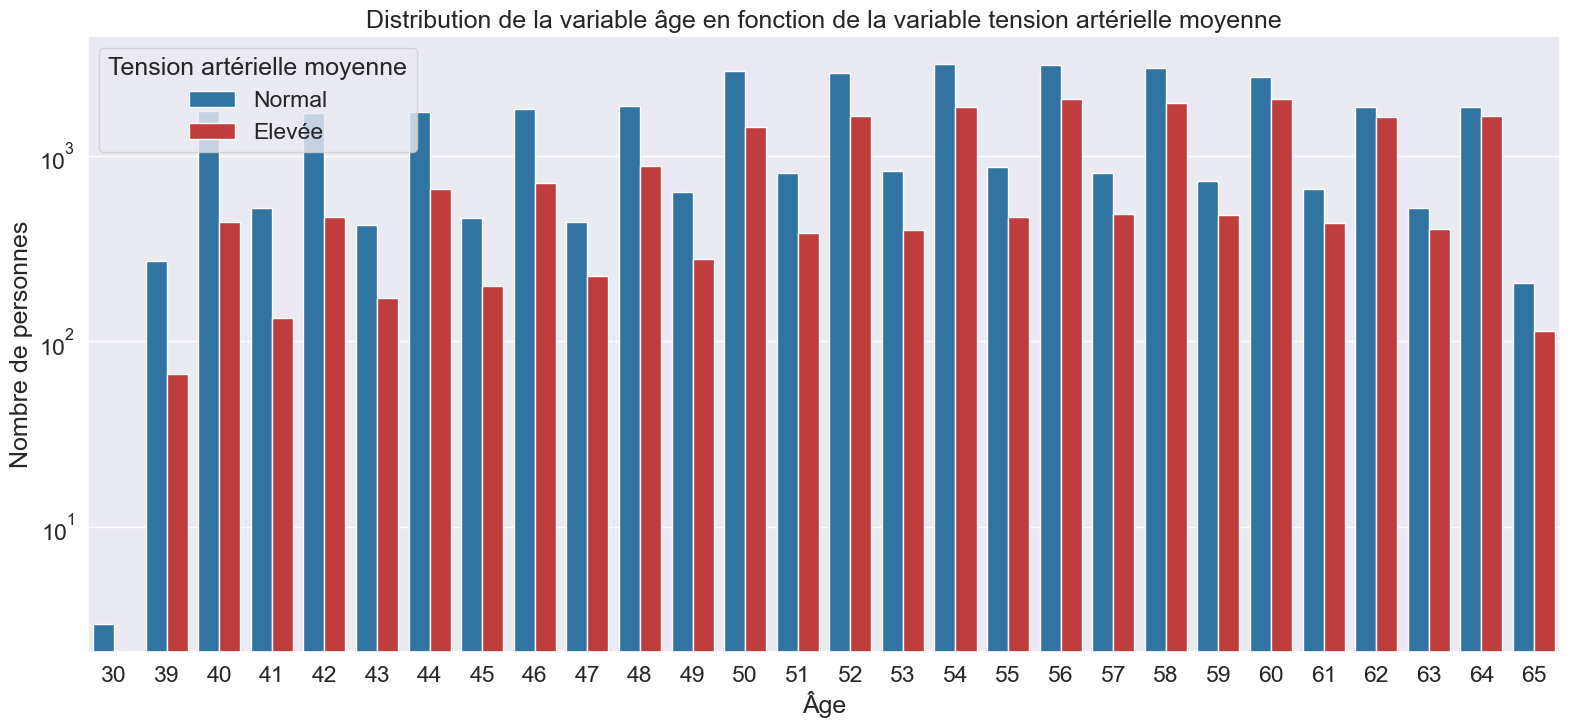

In [27]:
plt.figure(figsize=(19, 8))
sns.countplot(x='age', hue='map_cat', data=df, palette=artmean)
plt.title('Distribution de la variable âge en fonction de la variable tension artérielle moyenne')
plt.legend(loc='upper left', labels=['Normal', 'Elevée'], title='Tension artérielle moyenne')
plt.xlabel('Âge')
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

On observe ici que la tension artérielle moyenne augmente avec l'âge. 

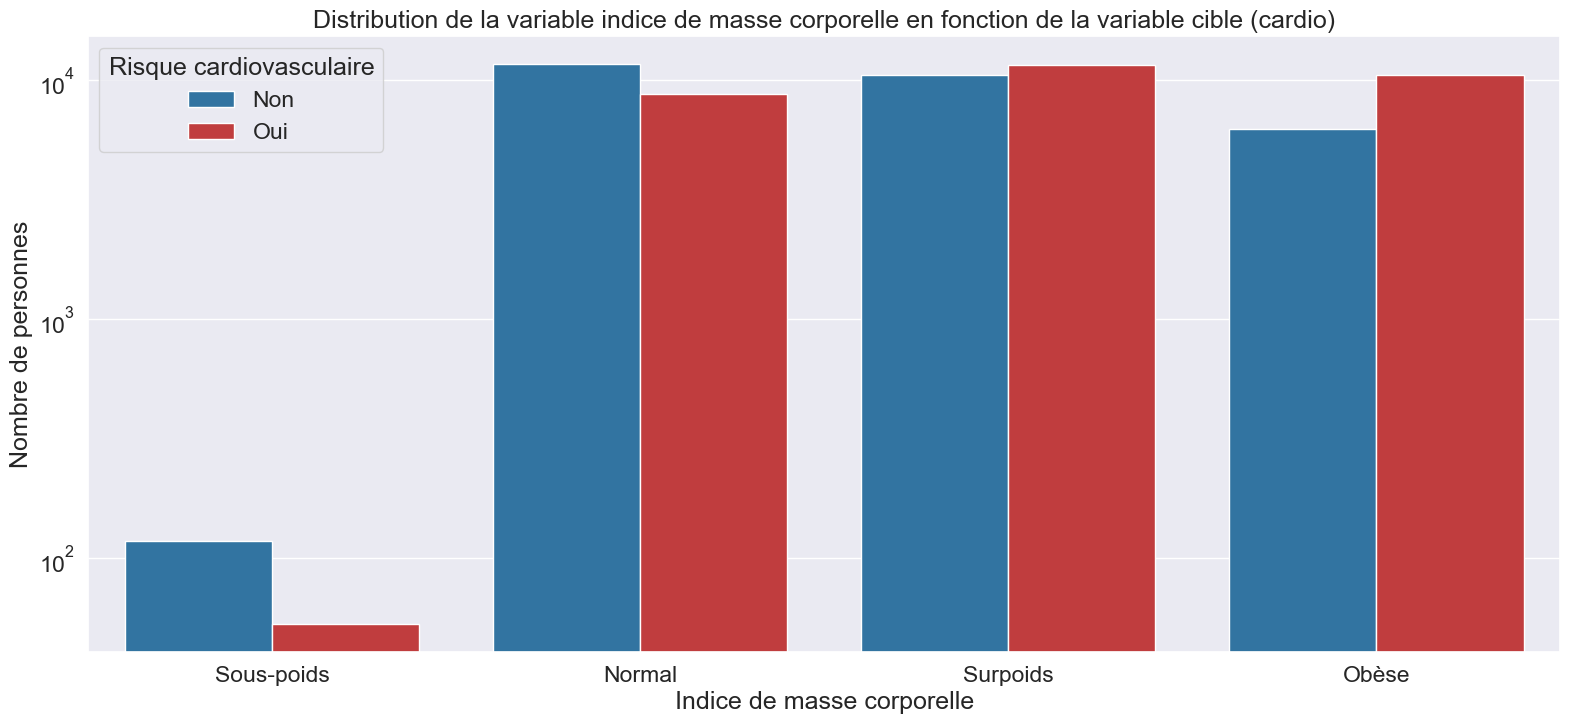

In [28]:
plt.figure(figsize=(19, 8))
sns.countplot(x='bmi_cat', hue='cardio', data=df, order=['Underweight', 'Normal', 'Overweight', 'Obese'], palette=carisk)
plt.title('Distribution de la variable indice de masse corporelle en fonction de la variable cible (cardio)')
plt.legend(loc='upper left', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Indice de masse corporelle')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Sous-poids', 'Normal', 'Surpoids', 'Obèse'])
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

On observe que le poids a une influence sur les risques de maladies.   
Ici, les personnes obèses représentent la catégorie de population la plus sujette aux risques de maladies cardio-vasculaire.

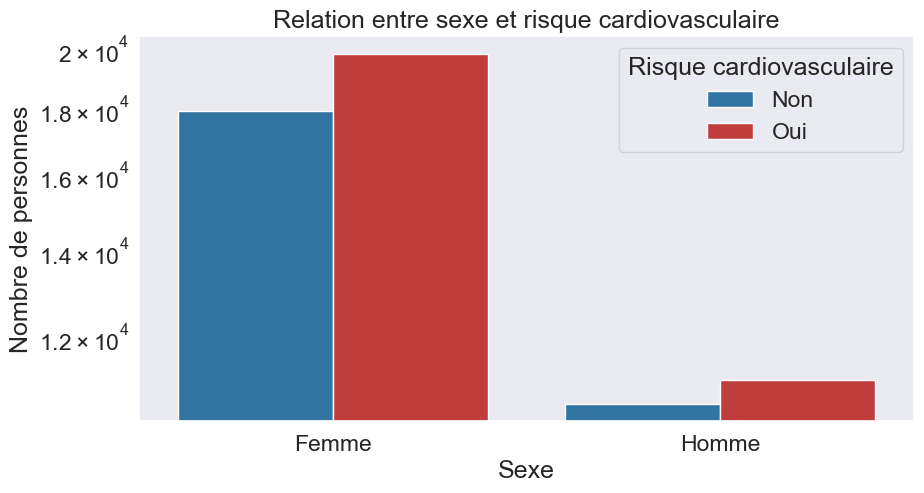

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(x='gender', hue='cardio', data=df, palette=carisk)
plt.title('Relation entre sexe et risque cardiovasculaire')
plt.legend(loc='upper right', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Sexe')
plt.xticks(ticks=[0, 1], labels=['Femme', 'Homme'])
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

Bien que notre population soit sur-représentée par le sexe féminin,   
On observe que, proportionnellement, il y a autant de risque de maladie cardio-vasculaire chez les hommes que chez les femmes.

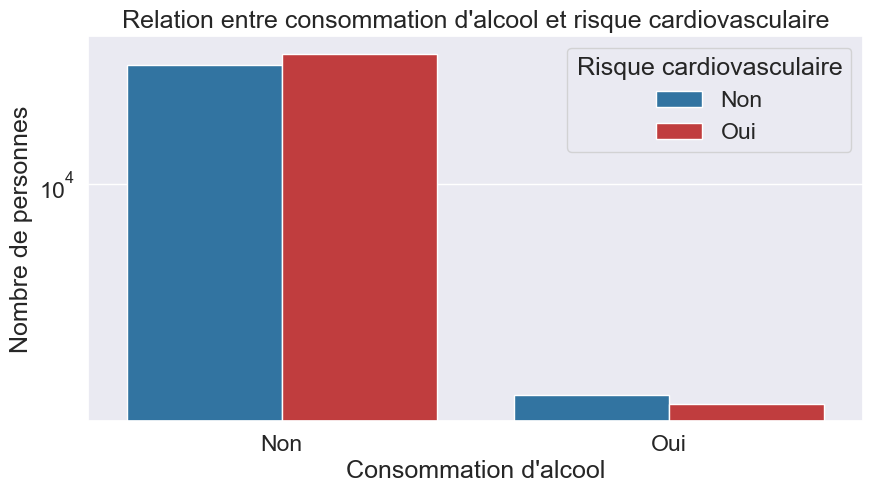

In [30]:
plt.figure(figsize=(10, 5))
sns.countplot(x='alco', hue='cardio', data=df, palette=carisk)
plt.title('Relation entre consommation d\'alcool et risque cardiovasculaire')
plt.legend(loc='upper right', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Consommation d\'alcool')
plt.xticks(ticks=[0, 1], labels=['Non', 'Oui'])
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

Bien que les non-consommateurs d'alcool soient sur-représentés dans notre jeu de données, il n'y a pas de lien réel entre consommation d'alcool et risque de maladie cardio-vasculaire.   
Si l'on en croit les chiffres : les patients qui consomment de l'alcool sont moins sujets aux risques de maladies cardio-vasculaire.

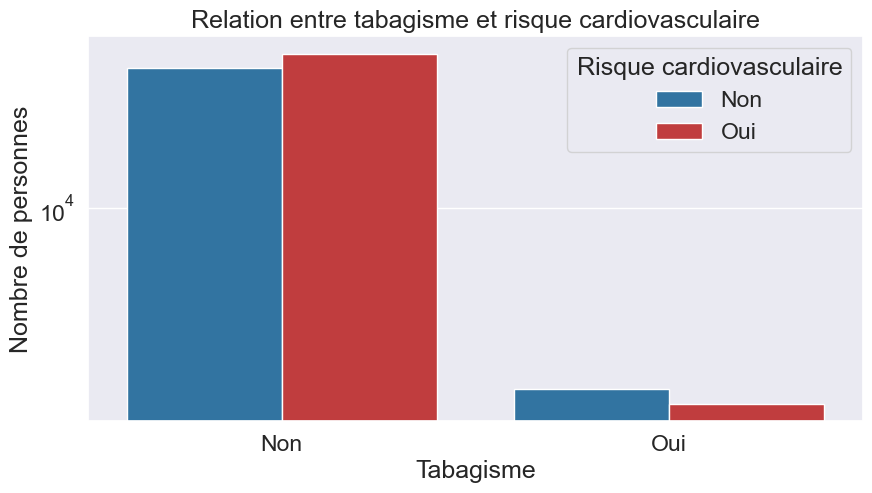

In [31]:
plt.figure(figsize=(10, 5))
sns.countplot(x='smoke', hue='cardio', data=df, palette=carisk)
plt.title('Relation entre tabagisme et risque cardiovasculaire')
plt.legend(loc='upper right', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Tabagisme')
plt.xticks(ticks=[0, 1], labels=['Non', 'Oui'])
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

Même constat que pour la consommation d'alcool, le tabagisme ne semble pas être un facteur déterminant quant aux risques de contracter une maladie cardio-vasculaire.   
Il semble même que les patients qui consomment du tabac sont moins sujets à un risque cardi-vasculaire.

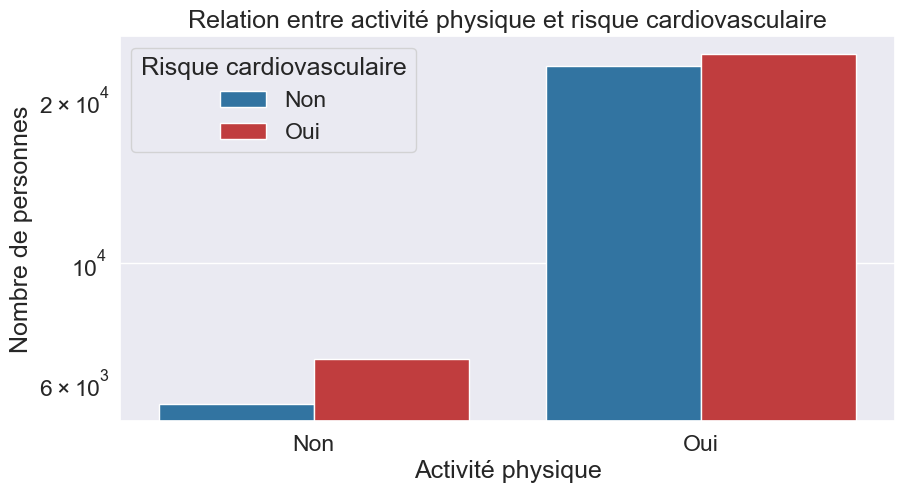

In [32]:
plt.figure(figsize=(10, 5))
sns.countplot(x='active', hue='cardio', data=df, palette=carisk)
plt.title('Relation entre activité physique et risque cardiovasculaire')
plt.legend(loc='upper left', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Activité physique')
plt.xticks(ticks=[0, 1], labels=['Non', 'Oui'])
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

On observe ici que les patients qui ne pratiquent pas d'activité physique sont signignificativement plus succeptibles de contracter une maladie cardio-vasculaire.   
Cependant ce risque, est aussi présent chez les patients pratiquants une activité physique.   
Cette variable, à elle seule, n'est pas déterminante quant à supposer une quelconque corrélation.

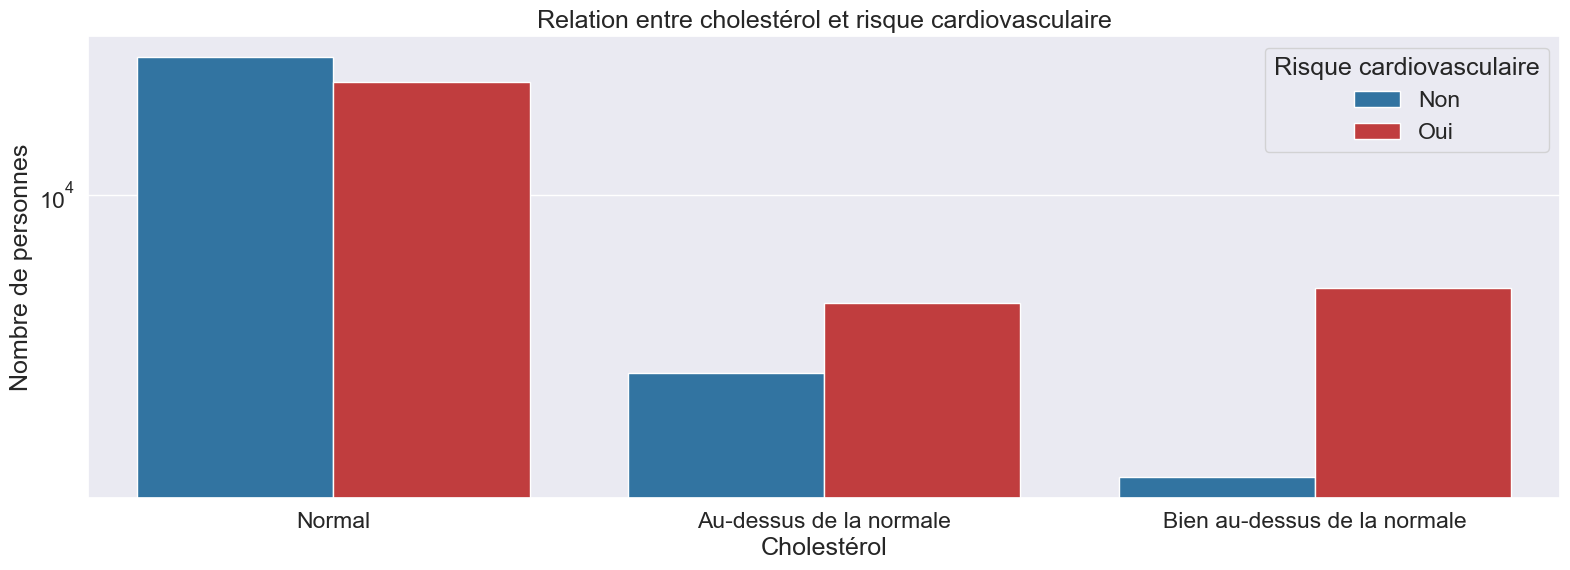

In [33]:
plt.figure(figsize=(19, 6))
sns.countplot(x='cholesterol', hue='cardio', data=df, palette=carisk)
plt.title('Relation entre cholestérol et risque cardiovasculaire')
plt.legend(loc='upper right', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Cholestérol')
plt.xticks(ticks=[0, 1, 2], labels=['Normal', 'Au-dessus de la normale', 'Bien au-dessus de la normale'])
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

On observe ici que plus le niveau de cholestérol augmente, plus les patients sont sujets à contracter des maladies cardio-vasculaires.

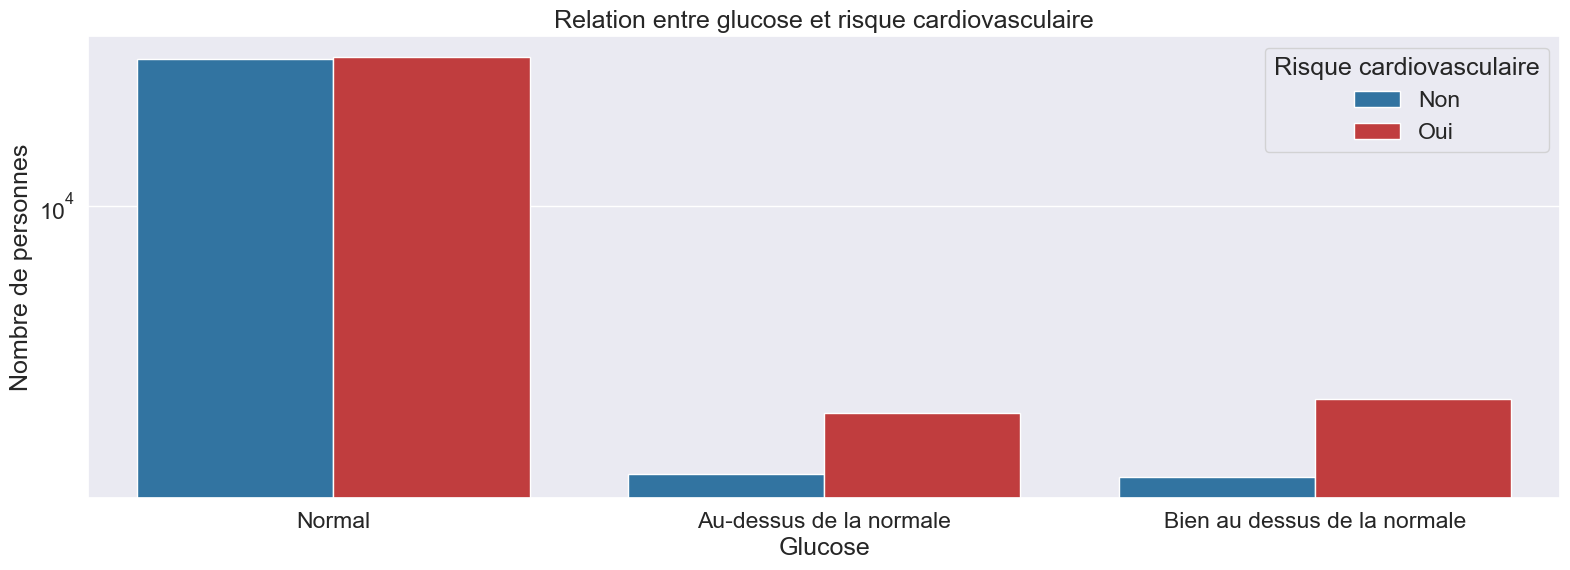

In [34]:
plt.figure(figsize=(19, 6))
sns.countplot(x='gluc', hue='cardio', data=df, palette=carisk)
plt.title('Relation entre glucose et risque cardiovasculaire')
plt.legend(loc='upper right', labels=['Non', 'Oui'], title='Risque cardiovasculaire')
plt.xlabel('Glucose')
plt.xticks(ticks=[0, 1, 2], labels=['Normal', 'Au-dessus de la normale', 'Bien au dessus de la normale'])
plt.ylabel('Nombre de personnes')
plt.yscale('log')
plt.show()

Même observation que pour le cholestérol,   
plus le niveau de glucose augmente, plus les patients sont sujets à contracter des maladies cardio-vasculaires.

### Résumé des observations faites grace aux différents graphes :
On remarque que, bien que certaines variables semblent être plus ou moins significatives que d'autres quant à l'observation du risque de maladies cardio-vasculaires,   
isolées les unes des autres elles ne sont pas plus pertinentes que ça.   


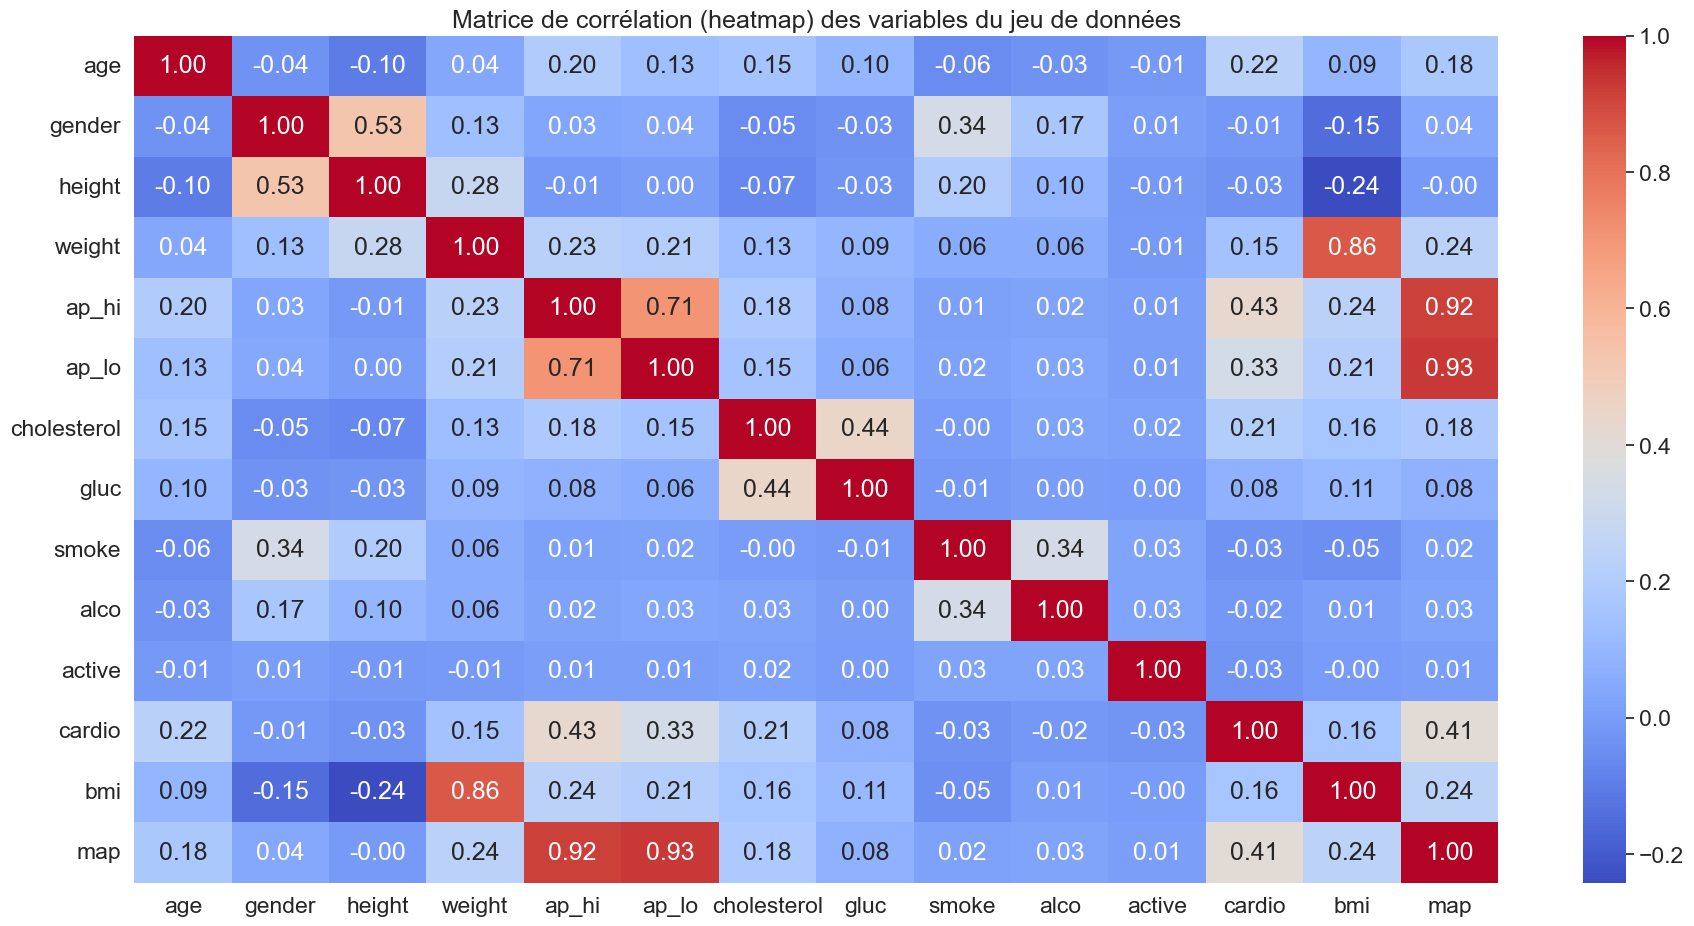

In [35]:
plt.figure(figsize=(22, 11))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation (heatmap) des variables du jeu de données')
plt.show()

Ici, les variables en étroite corrélation avec la contraction d'une maladie carido-casculaire sont :
- la pression artérielle systolique (ap_hi)
- la pression artérielle diastolique (ap_lo)
- la pression artérielle moyenne (map : calculée à l'aide des 2 variables citées au dessus)

## Réalisation d'une régression logistique
    Sklearn
    
    - Recherche des meilleurs hyper-paramètres
    - Test du modèle sur l'ensemble des données
    - Les métriques d'évaluation
    - Régressions logistique sur les 4 catégories de facteurs identifiés

### Afin de tester les hyperparamètres, on défini les variables dépendantes comme comprennant toutes les variables numériques de notre dataset, à l'exception de la variable cible (cardio) 
    'C' = inverse de la force de régularisation (plus 'C' est petit, plus la régularisation est forte)
    cv = nombre de folds pour validation croisée


In [36]:
# Séparation du dataset en variables dépendantes et indépendantes
X = df.drop(columns='cardio')
X = X.select_dtypes(include='number')
y = df['cardio']

# Initialisation du modèle de régression logistique
classifier = LogisticRegression(solver='liblinear')

# Définition de la grille des hyperparamètres
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(classifier, param_grid, cv=5)

# Entraînement du modèle
grid_search.fit(X, y)

# Affichage des meilleurs hyperparamètres
print(f'Meilleurs hyperparamètres: {grid_search.best_params_}')

# Affichage de la meilleure précision
print(f'Meilleure précision: {grid_search.best_score_:.2f}')

Meilleurs hyperparamètres: {'C': 10}
Meilleure précision: 0.72


### Conclusion : Les hyperparamètres sont des paramètres qui ne sont pas appris par le modèle, mais qui sont définis avant l'entraînement du modèle.   
#### Les hyperparamètres peuvent être optimisés pour améliorer les performances du modèles.
#### La recherche des meilleurs hyperparamètres peut être effectuée à l'aide de la validation croisée et de la grille des hyperparamètres.

In [37]:
# Séparation du dataset en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
# Initialisation du modèle de régression logistique
classifier = LogisticRegression(solver='liblinear', C=0.1)

In [39]:
# # Entraînement du modèle
# classifier.fit(X_train, y_train)
# Entraînement du modèle
classifier.fit(X.values, y)

LogisticRegression(C=0.1, solver='liblinear')

In [40]:
# Prédiction sur les données de test
y_pred = classifier.predict(X.values)

In [41]:
accuracy = accuracy_score(y, y_pred)
print(f'Précision du modèle: {accuracy:.2f}')

Précision du modèle: 0.72


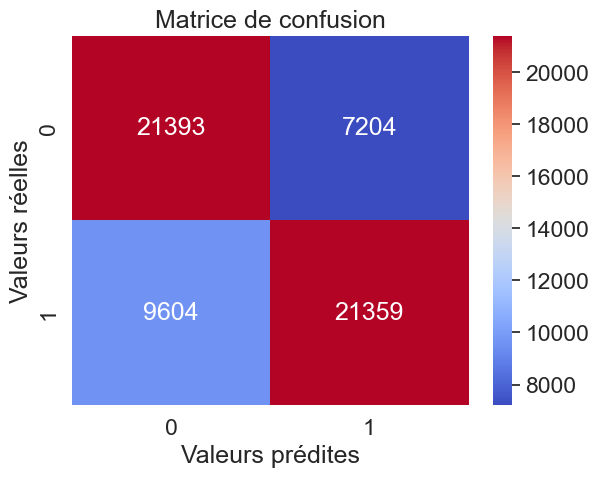

In [42]:
conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Matrice de confusion')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [43]:
class_report = classification_report(y, y_pred)
print('Rapport de classification')
print(class_report)

Rapport de classification
              precision    recall  f1-score   support

           0       0.69      0.75      0.72     28597
           1       0.75      0.69      0.72     30963

    accuracy                           0.72     59560
   macro avg       0.72      0.72      0.72     59560
weighted avg       0.72      0.72      0.72     59560



AUC: 0.79


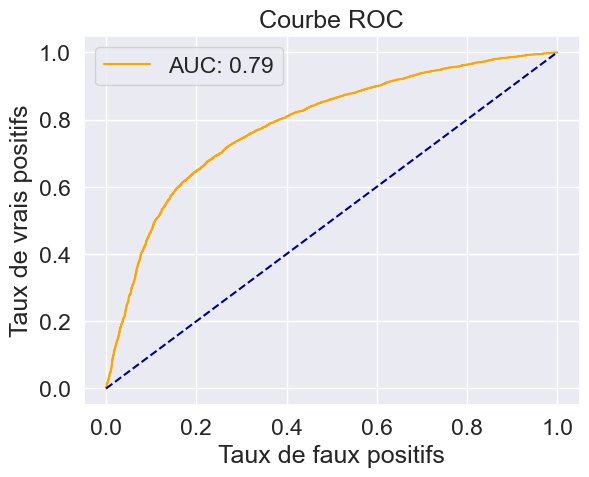

In [44]:
# Calcul des probabilités prédites
y_probs = classifier.predict_proba(X_test.values)

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_probs[:, 1])
print(f'AUC: {auc:.2f}')

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:, 1])

# Visualisation de la courbe ROC
plt.plot(fpr, tpr, color='orange', label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

### Les métriques d'évaluation.
    Avant d'aller plus loin, quelques notions élémentaires :
    - TP (True Positive) : Le modèle prédit Vrai et la prédiction est Vrai (donc juste).
    - TN (True Negative) : Le modèle prédit Vrai et la prédiction est Faux (donc fausse).
    - FP (False Positive) : Le modèle prédit Faux et la prédiction est Vrai (donc fausse).
    - FN (False Negative) : Le mdèle prédit Faux et la prédiction est Faux (donc juste).
    
- **Accuracy** :   
Simple mesure du taux de prédictions correctes effectuées par le modèle.   
On peut voir ça comme le ratio prédictions correctes/total des prédiciton.   
Se calcul de la manière suivante :
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

- **La matrice de confusion (Confusion Matrix)** :   
Mesure de rendement pour des problèmes de classification d'apprentissage automatique (ML) où la valeur prédite peut avoir 2 classes ou plus.
Représentée sous forme de table, metant ainsi en évidence les TP, FP, FN et TN.

\vec{v} = \begin{bmatrix} X \\\ Y \end{bmatrix}2 |

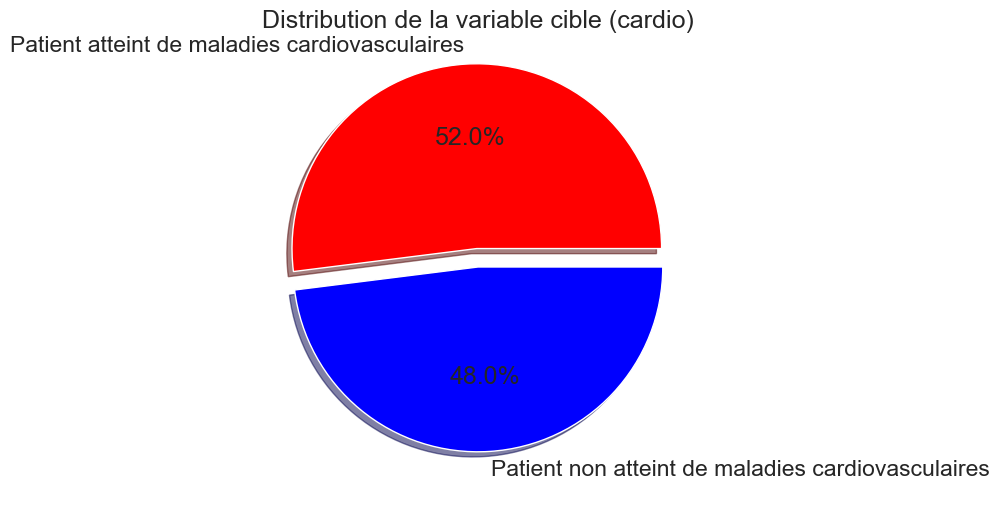

In [45]:
# visualisation des données, la variable cible est elle well balanced ? sous forme de pourcentage
plt.figure(figsize=(6, 6))
df['cardio'].value_counts().plot.pie(autopct='%1.1f%%', explode=(0.1, 0), shadow=True, labels=['Patient atteint de maladies cardiovasculaires', 'Patient non atteint de maladies cardiovasculaires'], colors=['red', 'blue'])
plt.title('Distribution de la variable cible (cardio)')
plt.ylabel('')
plt.show()

### Catégorisation des variables selon les facteurs d'appartenance. 
- Les facteurs non-modifiables :
    - Âge
    - Sexe
    - Taille
- Les facteurs liés au mode de vie :
    - Consommation d'alcool
    - Tabagisme
    - Sédentarité / Activité physique 
- Les facteurs cliniques en amont :
    - Obésité / IMC
- Les facteurs cliniques en aval :
    - Hypertension atrérielle
    - Taux de cholestérol
    - Taux de glucose

### Test de regression logistique sur les différentes catégories / Évaluation des modèles :

In [46]:
non_changeable_factors = df[['age','gender','height']]
lifestyle_factors = df[['alco','smoke','active']]
clinical_factors = df['bmi']
clinical_factors = df[['ap_hi','ap_lo','cholesterol','gluc']]
target = df['cardio']

In [47]:
# Séparation du dataset en variables dépendantes (y) et indépendantes (X)
X_1 = non_changeable_factors
X_2 = lifestyle_factors
X_3 = clinical_factors
X_4 = clinical_factors
y = target

In [48]:
# Séparation du dataset en données d'entraînement et de test pour les différentes catégories de facteurs
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y, test_size=0.2)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.2)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y, test_size=0.2)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y, test_size=0.2)

In [49]:
# Initialisation du modèle de régression logistique
classifier = LogisticRegression(solver='liblinear', C=0.1)

### - Facteurs non-modifiables :

In [50]:
# Entraînement du modèle pour la catégorie : Facteurs non-modifiables
classifier.fit(X_train_1, y_train_1)

LogisticRegression(C=0.1, solver='liblinear')

In [51]:
# Prédiction sur les données de test pour la catégorie : Facteurs non-modifiables
y_pred_1 = classifier.predict(X_test_1)

In [52]:
accuracy_1 = accuracy_score(y_test_1, y_pred_1)

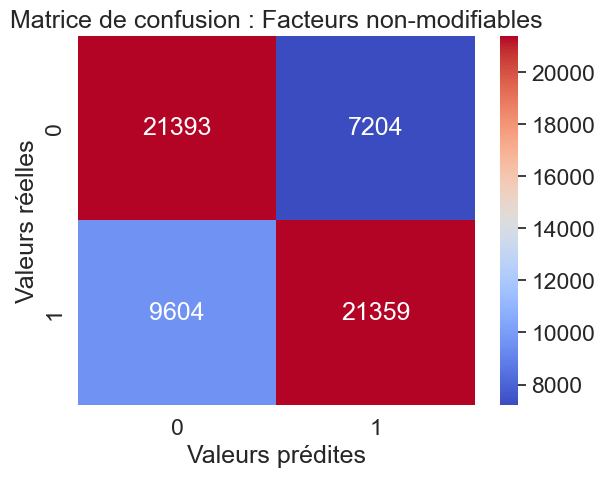

In [53]:
conf_matrix_1 = confusion_matrix(y_test_1, y_pred_1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Matrice de confusion : Facteurs non-modifiables')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [54]:
class_report_1 = classification_report(y_test_1, y_pred_1)

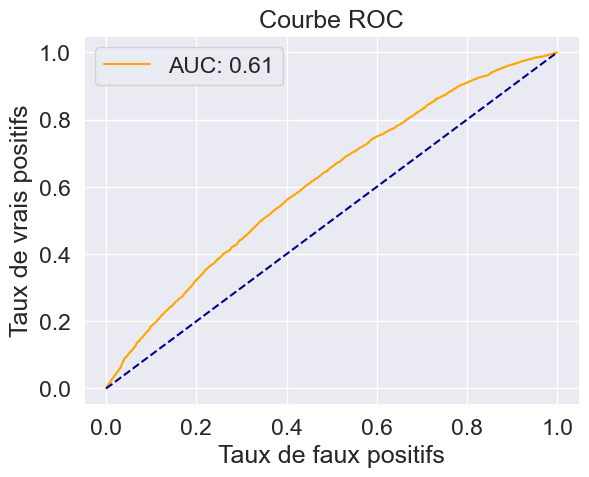

In [55]:

y_probs_1 = classifier.predict_proba(X_test_1)
auc_1 = roc_auc_score(y_test_1, y_probs_1[:, 1])
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_1, y_probs_1[:, 1])
plt.plot(fpr_1, tpr_1, color='orange', label=f'AUC: {auc_1:.2f}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

In [56]:
print('Rapport de classification : Facteurs non-modifiables')
print(class_report_1)
print(f'AUC (Facteurs non modifiables): {auc_1:.2f}')

Rapport de classification : Facteurs non-modifiables
              precision    recall  f1-score   support

           0       0.58      0.49      0.53      5727
           1       0.59      0.67      0.63      6185

    accuracy                           0.58     11912
   macro avg       0.58      0.58      0.58     11912
weighted avg       0.58      0.58      0.58     11912

AUC (Facteurs non modifiables): 0.61


### - Facteurs liés au mode de vie :

In [57]:
# Entraînement du modèle pour la catégorie : Facteurs liés au mode de vie
classifier.fit(X_train_2, y_train_2)

LogisticRegression(C=0.1, solver='liblinear')

In [58]:
# Prédiction sur les données de test pour la catégorie : Facteurs liés au mode de vie
y_pred_2 = classifier.predict(X_test_2)

In [59]:
accuracy_2 = accuracy_score(y_test_2, y_pred_2)

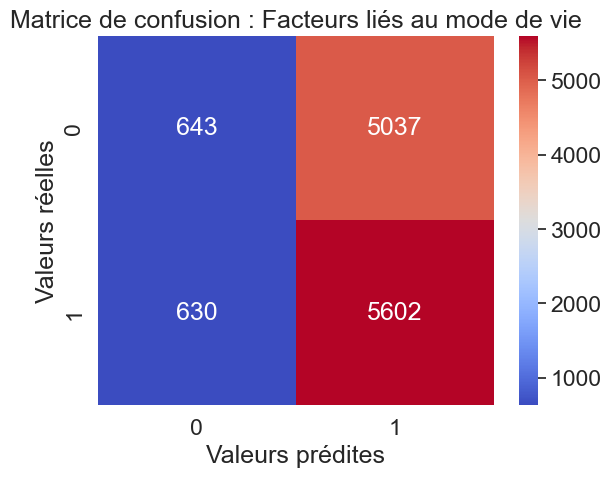

In [60]:
conf_matrix_2 = confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='coolwarm')
plt.title('Matrice de confusion : Facteurs liés au mode de vie')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [61]:
class_report_2 = classification_report(y_test_2, y_pred_2)

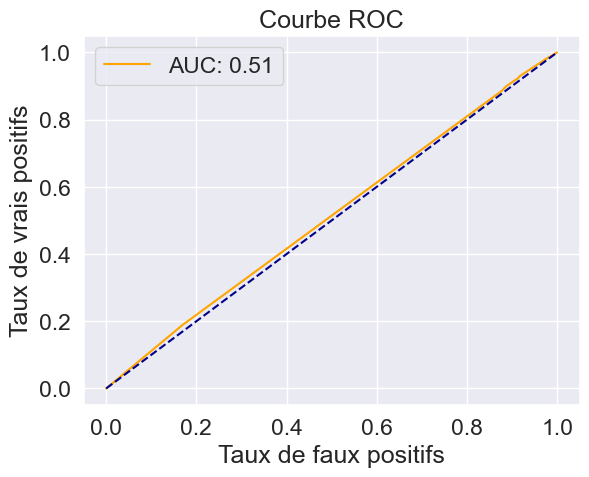

In [62]:
y_probs_2 = classifier.predict_proba(X_test_2)
auc_2 = roc_auc_score(y_test_2, y_probs_2[:, 1])
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test_2, y_probs_2[:, 1])
plt.plot(fpr_2, tpr_2, color='orange', label=f'AUC: {auc_2:.2f}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

In [63]:
print('Rapport de classification : Facteurs liés au mdoe de vie')
print(class_report_2)
print(f'AUC (Facteurs liés au mode de vie): {auc_2:.2f}')

Rapport de classification : Facteurs liés au mdoe de vie
              precision    recall  f1-score   support

           0       0.51      0.11      0.18      5680
           1       0.53      0.90      0.66      6232

    accuracy                           0.52     11912
   macro avg       0.52      0.51      0.42     11912
weighted avg       0.52      0.52      0.44     11912

AUC (Facteurs liés au mode de vie): 0.51


### - Facteurs cliniques en amont : 

In [64]:
# Entraînement du modèle pour la catégorie : Facteurs cliniques en amont
classifier.fit(X_train_3, y_train_3)

LogisticRegression(C=0.1, solver='liblinear')

In [65]:
# Prédiction sur les données de test pour la catégorie : Facteurs cliniques en amont
y_pred_3 = classifier.predict(X_test_3)

In [66]:
accuracy_3 = accuracy_score(y_test_3, y_pred_3)

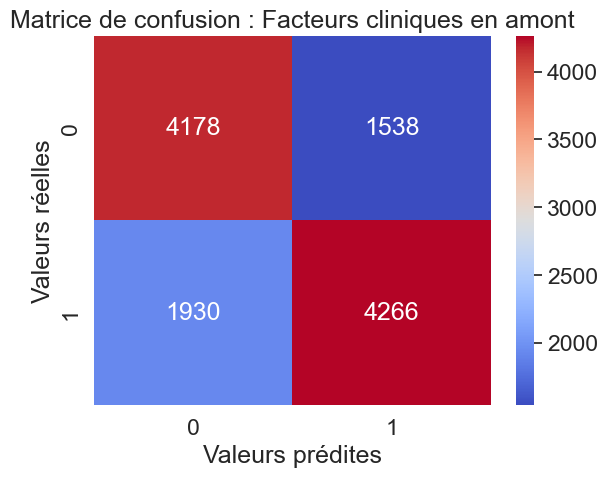

In [67]:
conf_matrix_3 = confusion_matrix(y_test_3, y_pred_3)
sns.heatmap(conf_matrix_3, annot=True, fmt='d', cmap='coolwarm')
plt.title('Matrice de confusion : Facteurs cliniques en amont')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [68]:
class_report_3 = classification_report(y_test_3, y_pred_3)

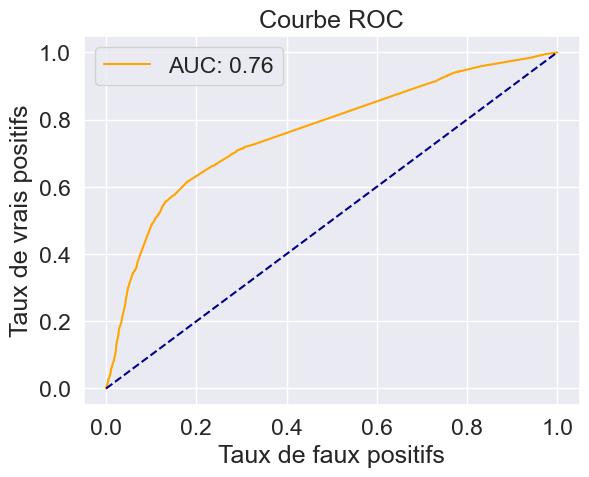

In [69]:
y_probs_3 = classifier.predict_proba(X_test_3)
auc_3 = roc_auc_score(y_test_3, y_probs_3[:, 1])
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test_3, y_probs_3[:, 1])
plt.plot(fpr_3, tpr_3, color='orange', label=f'AUC: {auc_3:.2f}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

In [70]:
print('Rapport de classification : Facteurs cliniques en amont')
print(class_report_3)
print(f'AUC (Facteurs cliniques en amont): {auc_3:.2f}')

Rapport de classification : Facteurs cliniques en amont
              precision    recall  f1-score   support

           0       0.68      0.73      0.71      5716
           1       0.74      0.69      0.71      6196

    accuracy                           0.71     11912
   macro avg       0.71      0.71      0.71     11912
weighted avg       0.71      0.71      0.71     11912

AUC (Facteurs cliniques en amont): 0.76


### - Facteurs cliniques en aval :

In [71]:
# Entraînement du modèle pour la catégorie : Facteurs cliniques en aval
classifier.fit(X_train_4, y_train_4)

LogisticRegression(C=0.1, solver='liblinear')

In [72]:
# Prédiction sur les données de test pour la catégorie : Facteurs cliniques en aval
y_pred_4 = classifier.predict(X_test_4)

In [73]:
accuracy_4 = accuracy_score(y_test_4, y_pred_4)

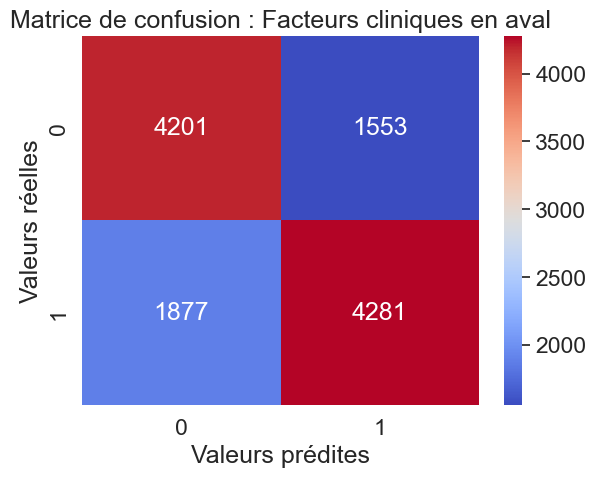

In [74]:
conf_matrix_4 = confusion_matrix(y_test_4, y_pred_4)
sns.heatmap(conf_matrix_4, annot=True, fmt='d', cmap='coolwarm')
plt.title('Matrice de confusion : Facteurs cliniques en aval')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()

In [75]:
class_report_4 = classification_report(y_test_4, y_pred_4)

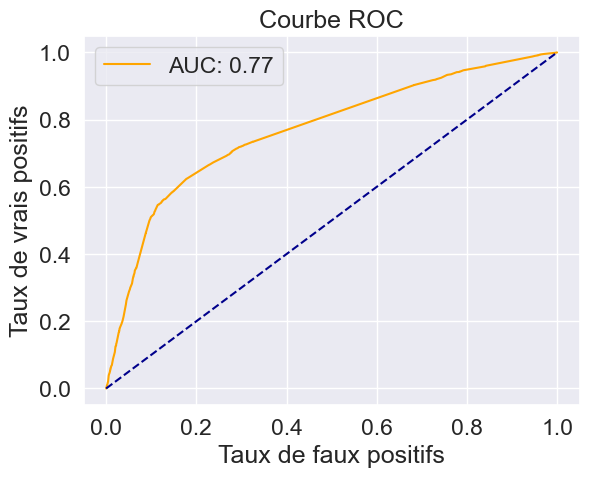

In [76]:
y_probs_4 = classifier.predict_proba(X_test_4)
auc_4 = roc_auc_score(y_test_4, y_probs_4[:, 1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_test_4, y_probs_4[:, 1])
plt.plot(fpr_4, tpr_4, color='orange', label=f'AUC: {auc_4:.2f}')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

In [77]:
print('Rapport de classification : Facteurs cliniques en aval')
print(class_report_4)
print(f'AUC (Facteurs cliniques en aval): {auc_4:.2f}')

Rapport de classification : Facteurs cliniques en aval
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      5754
           1       0.73      0.70      0.71      6158

    accuracy                           0.71     11912
   macro avg       0.71      0.71      0.71     11912
weighted avg       0.71      0.71      0.71     11912

AUC (Facteurs cliniques en aval): 0.77


### Comparatif des modèles selon les facteurs utilisés comme variables d'entrées : 

In [78]:
eval = {
    'non-modifiables':accuracy_1,
    'liés au mode de vie':accuracy_2,
    'cliniques en amont': accuracy_3,
    'cliniques en aval': accuracy_4
}

for key, value in eval.items():
    print(f'Précision pour les facteurs {key}: {value:.2f}')

Précision pour les facteurs non-modifiables: 0.58
Précision pour les facteurs liés au mode de vie: 0.52
Précision pour les facteurs cliniques en amont: 0.71
Précision pour les facteurs cliniques en aval: 0.71


### Prédiction pour Arthur : 

In [79]:
age = 53
gender = 2
height = 175
weight = 85.0
ap_hi = 50
ap_lo = 50
cholesterol = 1
gluc = 1
smoke = 0
alco = 0
active = 1

In [80]:
# # prediction = classifier.predict([[50, 2, 175, 85.0, 50, 50, 1, 1, 1, 0, 1]])
# prediction = classifier.predict([[age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active]])
# pred_answer = ''
# if prediction[0] == 0:
#     pred_answer = 'Non'
# else:
#     pred_answer = 'Oui'
# print(f'Le patient est-il sujet à une maladie cardio-vasculaire: {pred_answer}.')